# 24/10/03 - Estudos de redes com de 3 e 4 camadas e de 8 a 32 neurônios e validação no treino



## Resumo

- Função de perda: RMSE
- Parânmetros do modelo: k--0.1__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0
- Funções de  ativação: 
    - Elu 
    - Tanh
    - ReLU
    - SiLU

- Tamanhos de batelada e épocas:
    - (800, 1090)

- Arquivo de checkpoint: 
    - 1727462177
    - 1727975986

- Peso da perda de cond. inicial: 10

- Peso da perda de dados: 10

## Análise de erro vs speedup

In [1]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [2]:
result_list = glob.glob("pinn_sim/output_*")

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 225


In [3]:
i = 0

results_dict = {}

for file in result_list:
    with open(file, "rb") as f:
        aux_dict = pk.load(f)

    if not np.isnan( aux_dict["rmse"] ):
        
        results_dict[i] = aux_dict 

        results_dict[i]["file"] = file.split("pinn_sim/output_")[-1]
            
        layers_list = file.split("/")[-1].split(".pkl")[0].split("__")[2:]

        results_dict[i]["arch_name"] = ("__").join(layers_list)
        
        results_dict[i]["n_layers"] = len(layers_list)

        n_neurons = 0

        for layer in layers_list:

            n_neurons += int(layer)

        results_dict[i]["n_neurons"] = n_neurons

        results_dict[i]["n_layers"] = len(layers_list)
        
        i += 1
            

In [4]:
results_df = pd.DataFrame.from_dict(
    results_dict,
    orient='index'
)

results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218 entries, 0 to 217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_speed_up       218 non-null    float64
 1   std_speed_up        218 non-null    float64
 2   mean_speed_comp_up  218 non-null    float64
 3   std_speed_comp_up   218 non-null    float64
 4   mean_speed_up_pinn  218 non-null    float64
 5   std_speed_up_pinn   218 non-null    float64
 6   mean_serial_time    218 non-null    float64
 7   std_serial_time     218 non-null    float64
 8   mean_cuda_time      218 non-null    float64
 9   std_cuda_time       218 non-null    float64
 10  mean_pinn_time      218 non-null    float64
 11  std_pinn_time       218 non-null    float64
 12  rmse                218 non-null    float64
 13  max_ae              218 non-null    float64
 14  file                218 non-null    object 
 15  arch_name           218 non-null    object 
 16  n_layers     

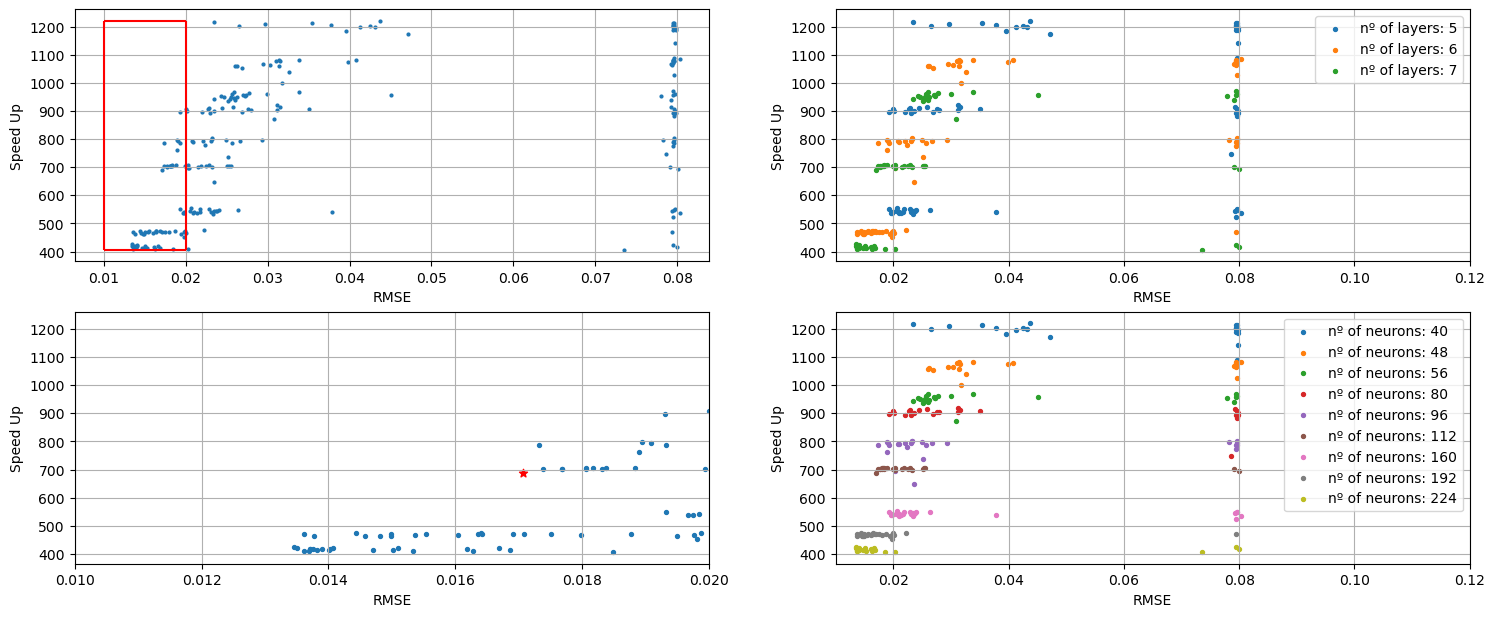

Arquitetura escolhida: 16__16__16__16__16__16__16
Erro absoluto médio 0.017071734234020145
Erro absoluto máximo 0.6275107860565186
Speed Up: 688.5530533772531 +/-30.806961377119453


In [5]:
x_lim = (0.01, 0.020)

fig = plt.figure(figsize=[30 * 0.6, 12 * 0.6])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

ax = fig.add_subplot(2, 2, 1)

ax.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=4)
ax.hlines(max(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax.hlines(min(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax.vlines(x_lim[1], min(results_df.mean_speed_up_pinn), max(results_df.mean_speed_up_pinn), color="r")
ax.vlines(x_lim[0], min(results_df.mean_speed_up_pinn), max(results_df.mean_speed_up_pinn), color="r")

choice = np.intersect1d(
    np.argwhere(np.array(results_df.mean_speed_up_pinn) > 600),
    np.argwhere(np.array(results_df.rmse) < 0.0173),
)[0]

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")

ax.grid()

ax = fig.add_subplot(2, 2, 3)

ax.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=8)
ax.scatter(results_df.rmse[choice], results_df.mean_speed_up_pinn[choice], c="r", marker="*")
ax.set_xlim(x_lim[0], x_lim[1])

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")

ax.grid()


ax = fig.add_subplot(2, 2, 2)

unique_n_layers = np.unique(results_df.n_layers)

for n_layers in unique_n_layers:
    sub_df = results_df[results_df.n_layers == int(n_layers)]

    ax.scatter(
        sub_df.rmse, sub_df.mean_speed_up_pinn, s=8, label="nº of layers: {}".format(int(n_layers))
    )

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")
ax.legend()
ax.set_xlim(x_lim[0], 0.12)
ax.grid()

ax = fig.add_subplot(2, 2, 4)

unique_n_neurons = np.unique(results_df.n_neurons)

for n_neurons in unique_n_neurons:
    sub_df = results_df[results_df.n_neurons == int(n_neurons)]

    ax.scatter(
        sub_df.rmse,
        sub_df.mean_speed_up_pinn,
        s=8,
        label="nº of neurons: {}".format(int(n_neurons)),
    )

ax.set_xlabel("RMSE")
ax.set_ylabel("Speed Up")
ax.legend()
ax.set_xlim(x_lim[0], 0.12)
ax.grid()

plt.show()

best_model = results_df.iloc[choice]

arch_str = best_model["arch_name"]

print("Arquitetura escolhida: " + arch_str)
print("Erro absoluto médio", best_model["rmse"])
print("Erro absoluto máximo", best_model["max_ae"])
print(
    "Speed Up: {} +/-{}".format(
        best_model["mean_speed_up_pinn"], best_model["std_speed_up"]
    )
)


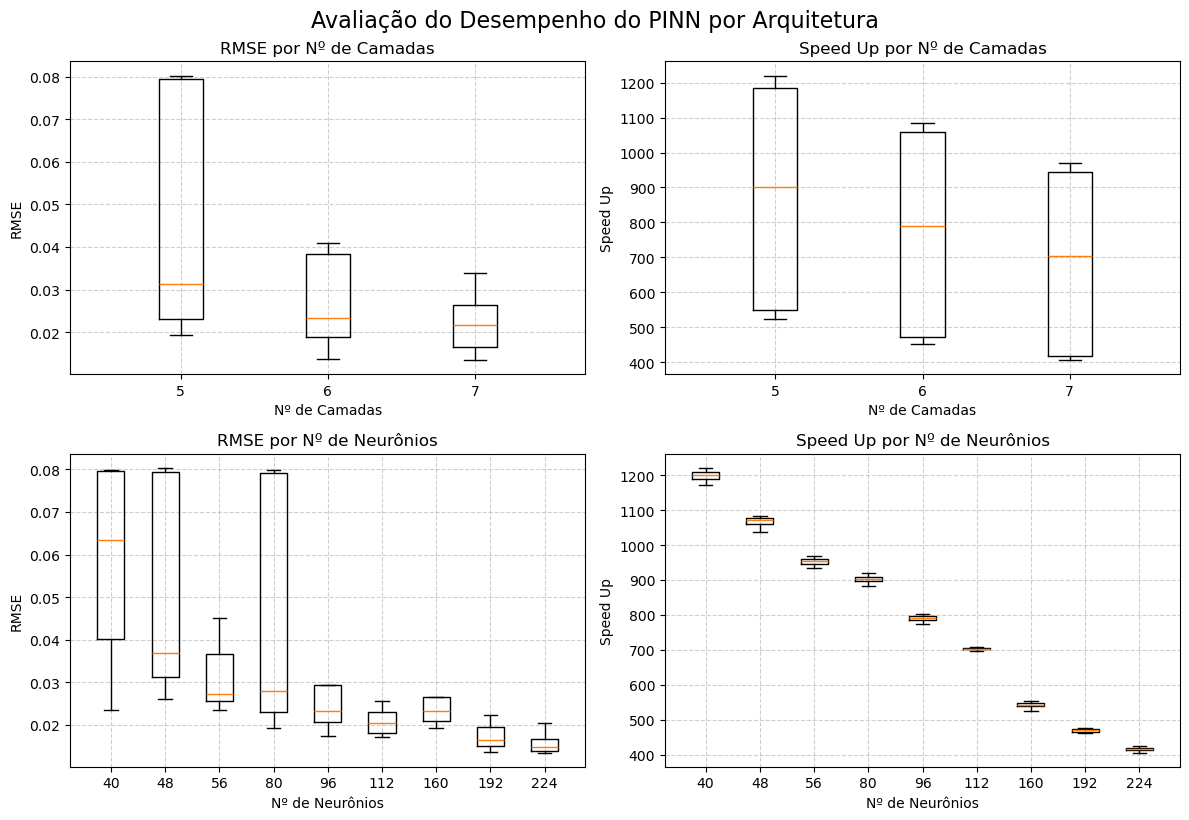

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def set_axis_style(ax, labels, xlabel, ylabel, title):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.6)

fig = plt.figure(figsize=(12, 8))

# Gráfico 1: RMSE por nº de camadas
ax = fig.add_subplot(2, 2, 1)
unique_n_layers = np.unique(results_df.n_layers)
collection = [results_df[results_df.n_layers == n].rmse for n in unique_n_layers]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False)
set_axis_style(ax, unique_n_layers, "Nº de Camadas", "RMSE", "RMSE por Nº de Camadas")

# Gráfico 2: Speed up por nº de camadas
ax = fig.add_subplot(2, 2, 2)
collection = [results_df[results_df.n_layers == n].mean_speed_up_pinn for n in unique_n_layers]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False)
set_axis_style(ax, unique_n_layers, "Nº de Camadas", "Speed Up", "Speed Up por Nº de Camadas")

# Gráfico 3: RMSE por nº de neurônios
ax = fig.add_subplot(2, 2, 3)
unique_n_neurons = np.unique(results_df.n_neurons)
collection = [results_df[results_df.n_neurons == n].rmse for n in unique_n_neurons]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False)
set_axis_style(ax, unique_n_neurons, "Nº de Neurônios", "RMSE", "RMSE por Nº de Neurônios")

# Gráfico 4: Speed up por nº de neurônios
ax = fig.add_subplot(2, 2, 4)
collection = [results_df[results_df.n_neurons == n].mean_speed_up_pinn for n in unique_n_neurons]
ax.boxplot(collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False)
set_axis_style(ax, unique_n_neurons, "Nº de Neurônios", "Speed Up", "Speed Up por Nº de Neurônios")

plt.tight_layout()
plt.suptitle("Avaliação do Desempenho do PINN por Arquitetura", fontsize=16, y=1.02)
plt.show()


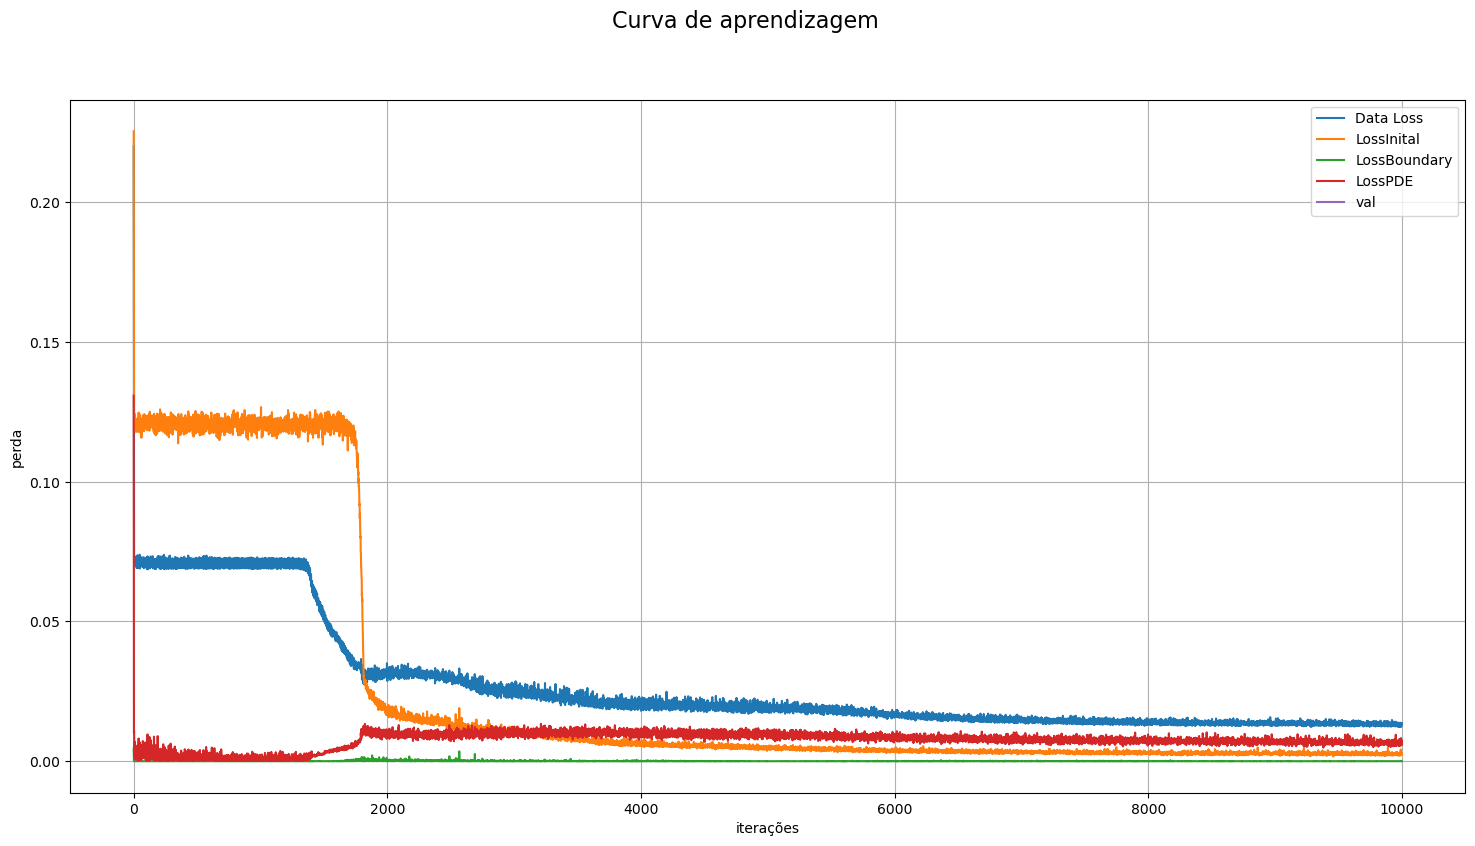

In [7]:
with open("learning_curves/" + best_model['file'], "rb") as f:
    loss_dict = pk.load(f)

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

for loss in loss_dict:
    ax.plot(
        range(len(loss_dict[loss])),
        loss_dict[loss],
        label=loss,
    )

# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [8]:
import pickle as pk
import json
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    leu_source_points,
)

Steps in time = 1001
Steps in space_x = 100
Steps in space_y = 1

device: cuda


In [9]:
from utils import animate_1D_comparison, plot_comparison

with open("pinn_sim/prediction_" + best_model['file'], "rb") as f:
    # Reading from json file
    prediction = pk.load(f)
    
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

pred_pinn = prediction["pred_pinn"]

target = prediction["target"]

Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)

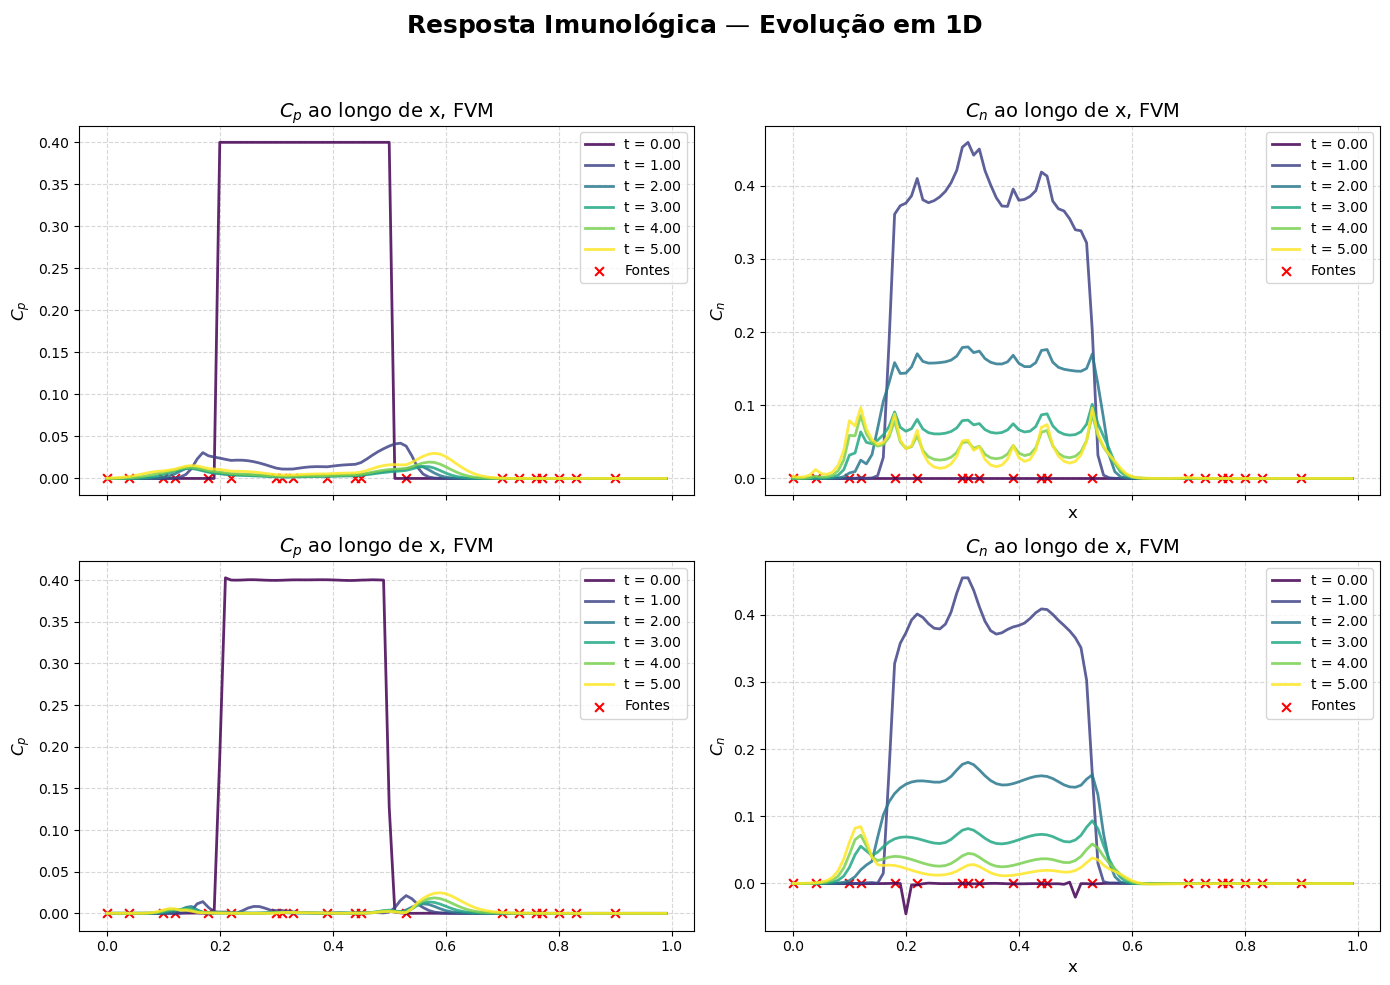

In [10]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
)


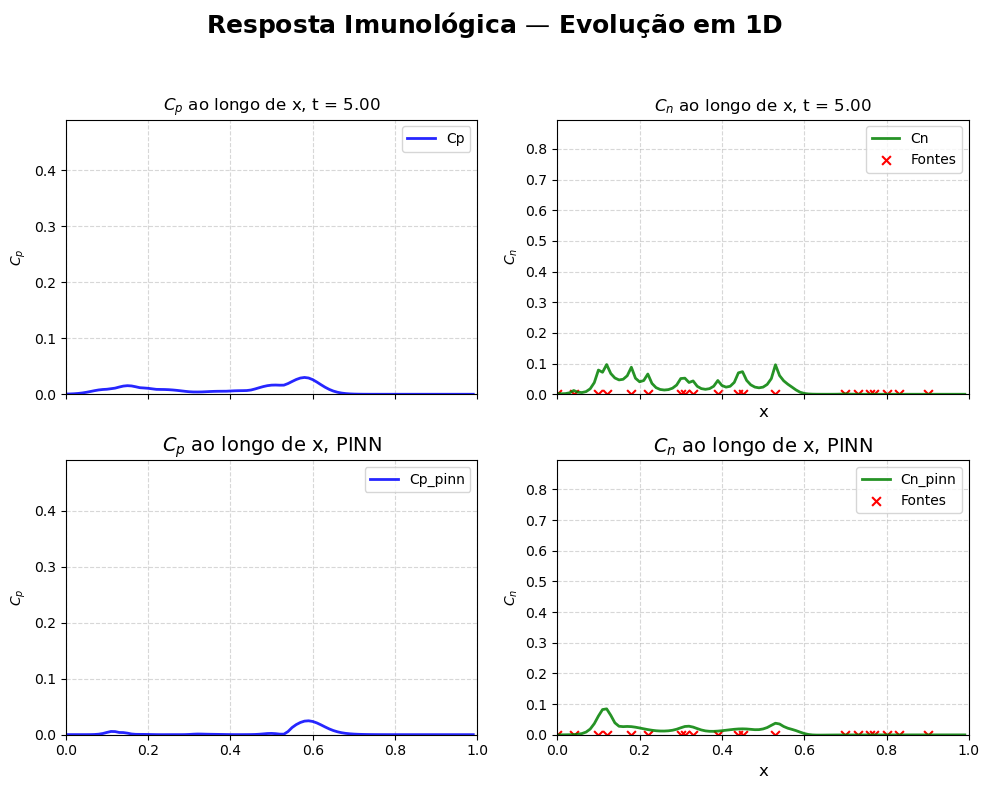

In [11]:
animate_1D_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
    leu_source_points,
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__pinn",
)
